In [36]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import *

In [37]:
reddit = pd.read_csv('../data/reddit_data_cleaned.csv')

In [38]:
reddit.columns

Index(['title', 'comments', 'subreddit', 'hours_ago', 'upvotes',
       'scraped_time', 'contains_image', 'contains_video', 'text_only',
       'posted_time', 'target', 'title_len', 'title_emoji', 'posted_hour',
       'posted_weekday', 'stemmed_title', 'post_id'],
      dtype='object')

In [39]:
columns = ['contains_image','contains_video',
           'text_only','title_len']

for column in columns:
    print(reddit.groupby('target')[column].mean())

target
0    0.582586
1    0.450604
Name: contains_image, dtype: float64
target
0    0.204154
1    0.167709
Name: contains_video, dtype: float64
target
0    0.213259
1    0.381687
Name: text_only, dtype: float64
target
0     9.380993
1    11.606920
Name: title_len, dtype: float64


Here we begin to see some interesting discrepancies between successful and unsuccessful posts. For example, 58% of unsuccessul posts contain an image, while only 45% of successful posts contain an image. 38% of successful posts are text only while only 21% of unsuccesful posts are text only. 

''

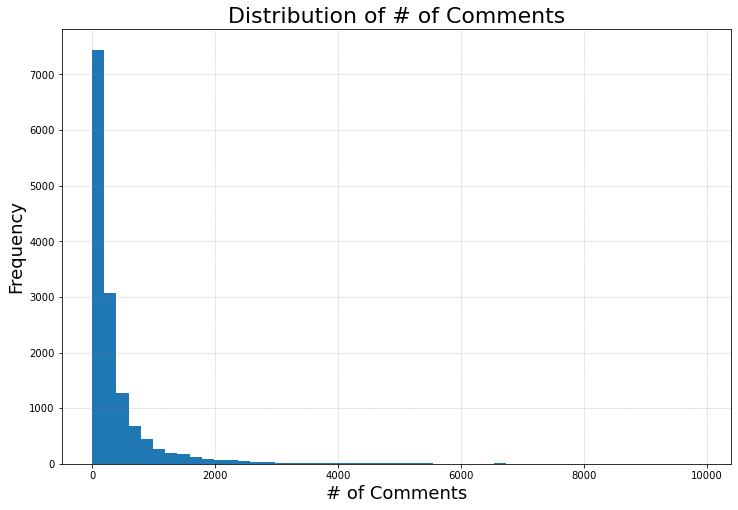

In [40]:
#examining the distribution of the comments column
plt.figure(figsize=(12, 8))
plt.hist(reddit['comments'], bins = 50)
plt.title('Distribution of # of Comments', size = 22)
plt.xlabel('# of Comments', size = 18)
plt.ylabel('Frequency', size = 18)
plt.grid(color='grey', linestyle=':', linewidth=0.5)
;


The distribution of our target variable is very skewed. We see a huge number of posts that receive <500 comments

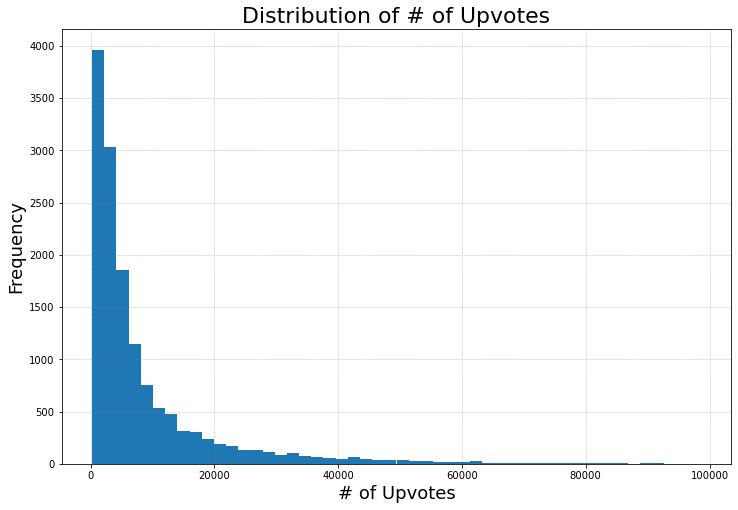

In [41]:
#examining the distribution of the upvotes column
plt.figure(figsize=(12, 8))
plt.hist(reddit['upvotes'], bins = 50)
plt.title('Distribution of # of Upvotes', size = 22)
plt.xlabel('# of Upvotes', size = 18)
plt.ylabel('Frequency', size = 18)
plt.grid(color='grey', linestyle=':', linewidth=0.5)

upvotes follows a similar distribution to comments, with a slightly more even spread. 

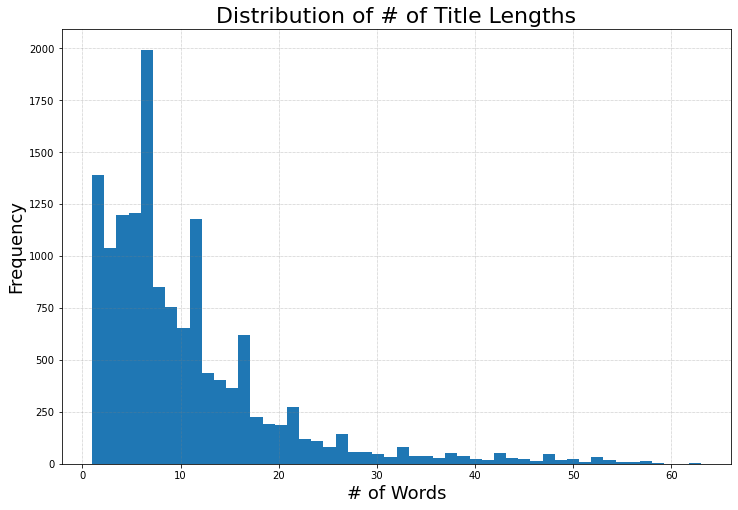

In [42]:
#examining the distribution of the title length column
plt.figure(figsize=(12, 8))
plt.hist(reddit['title_len'], bins = 50)
plt.title('Distribution of # of Title Lengths', size = 22)
plt.xlabel('# of Words', size = 18)
plt.ylabel('Frequency', size = 18)
plt.grid(color='grey', linestyle=':', linewidth=0.5)

The majority of our titles have 10 or fewer words in them.

In [43]:
reddit.groupby('target').mean()[columns]

,contains_image,contains_video,text_only,title_len
target,,,,
0,0.582586,0.204154,0.213259,9.380993
1,0.450604,0.167709,0.381687,11.606920


We see a significant disparity in the number of upvotes that successful posts recieve, so next we will examine a scatter plot to determine if there is a significant degree of multicolinearity. There is also a large discrepancy in the percentage of text only posts that are unsuccessful vs successful. We will keep an eye out for further insight on this relationship when modeling the data. 


In [44]:
#checking the correlation value between comments and upvotes
temp_df = reddit[['comments', 'upvotes']]
temp_df.corr()

,comments,upvotes
comments,1.000000,0.472353
upvotes,0.472353,1.000000


Among points with <5,000 comments, there seems to be a losely linear relationship between number of upvotes and the corresponding number of comments. When we check the correlation value, we see that there is a low degree of correlation, with a corr value of only 0.36

<ipython-input-45-bfbed07be750>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['type'] = types
<ipython-input-45-bfbed07be750>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['type'] = temp_df['type'].apply(post_type)


''

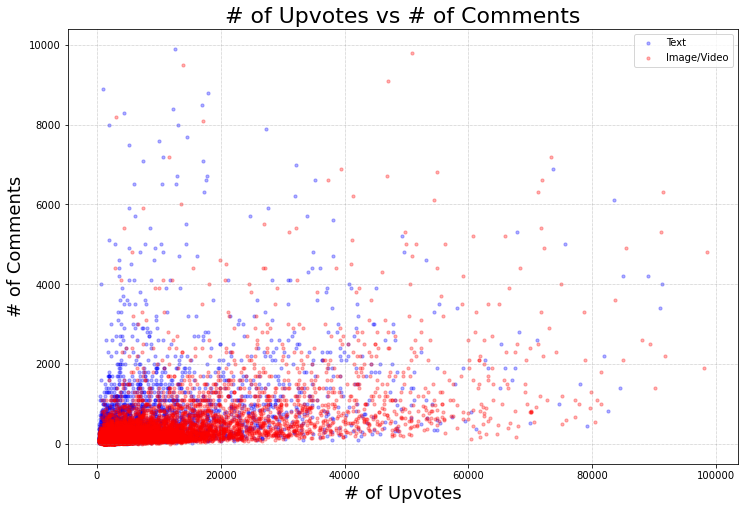

In [45]:
#try combining image and video into one category

temp_df = reddit[['contains_video','contains_image','text_only']]
types = list(temp_df.idxmax(axis=1))

temp_df = reddit[['comments','upvotes']]

temp_df['type'] = types

def post_type(x):
    if x == 'contains_image':
        return 'video/image'
    if x == 'contains_video':
        return 'video/image'
    if x == 'text_only':
        return 'text'
temp_df['type'] = temp_df['type'].apply(post_type)

temp_df_text = temp_df[temp_df['type']=='text']
temp_df_vid = temp_df[temp_df['type']=='video/image']

colors = {'text':'blue', 'video/image':'red'}

plt.figure(figsize=(12, 8))
plt.scatter('upvotes', 'comments', data=temp_df_text, s=10, alpha = 0.30, c='blue')
plt.scatter('upvotes', 'comments', data=temp_df_vid, s=10, alpha = 0.30, c='red')
plt.title('# of Upvotes vs # of Comments', size = 22)
plt.xlabel('# of Upvotes', size = 18)
plt.ylabel('# of Comments', size = 18)
plt.grid(color='grey', linestyle=':', linewidth=0.5)
plt.legend(['Text','Image/Video'])
plt.savefig('../visualizations/comments_v_upvotes')
;

In [46]:
temp_df['type'].value_counts()

video/image    9980
text           4246
Name: type, dtype: int64

When we split our data by the post content, we see an interesting trend begin to form. Text only posts inhabit a space with relatively few upvotes and a lot of comments, while posts that contain video or images tend to have far more upvotes and fewer comments. This makes sense, as text based posts are often asking questions or somehow encouraging the community to engage with posts via commenting rather than upvoting. 

In [47]:
#convert scrape_time to a date time object
reddit['posted_time'] = reddit['posted_time'].apply(
    lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f'))

In [48]:
#extracting the hour from the posted_time column

hours = []
for time in reddit['posted_time']:
    hours.append(time.hour)

reddit['posted_hour'] = hours

reddit['posted_hour'] = reddit['posted_hour'].apply(lambda x: 24 if x == 0 else x)

In [49]:
reddit['posted_hour'].value_counts()

4     1349
5     1265
6     1176
3      997
7      864
2      764
8      628
1      598
9      562
10     560
24     550
12     471
11     468
23     444
13     409
14     373
20     355
18     350
19     348
22     347
21     346
17     339
15     332
16     331
Name: posted_hour, dtype: int64

In [50]:
#creating a column indicating what day of the week the post was posted
#1 = monday

weekdays = []

for time in reddit['posted_time']:
    weekdays.append(time.weekday())

reddit['posted_weekday'] = weekdays
reddit['posted_weekday'] = reddit['posted_weekday'] + 1

In [51]:
success = reddit[reddit['target'] == 1]
fail = reddit[reddit['target'] == 0]

''

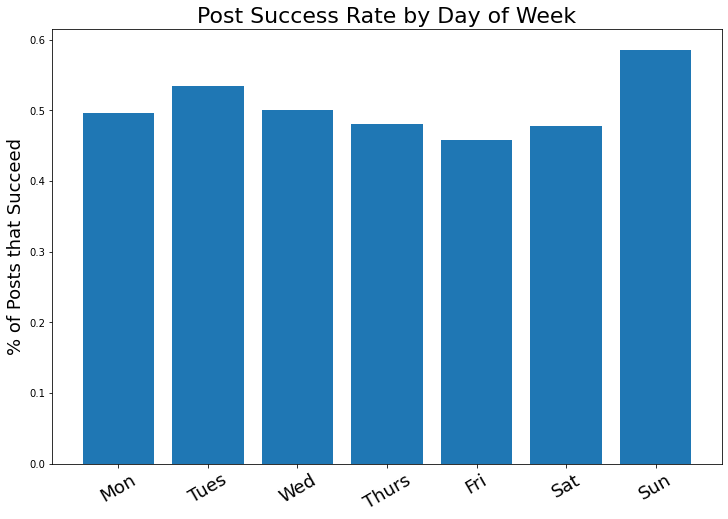

In [52]:
# visualize percentage of posts that succeed on each day of the week
temp_df = pd.DataFrame(
    reddit.groupby('posted_weekday')['target'].mean().reset_index())
#labels
days_of_week = ['Mon',
                'Tues',
                'Wed',
                'Thurs',
                'Fri',
                'Sat',
                'Sun']

plt.figure(figsize=(12, 8))
plt.bar('posted_weekday','target', data = temp_df)
plt.title('Post Success Rate by Day of Week', size = 22)
plt.xticks([1, 2, 3, 4, 5, 6, 7], days_of_week, size = 18, rotation = 30)
plt.ylabel('% of Posts that Succeed', size = 18)
;


we see slightly higher success rates on tuesdays and sundays than during the rest of the week, with thursday and friday having the lowest average success rates. 

In [53]:
#creating a temporary data frame that allows me to chart the % of successful posts by hour
temp_df = reddit.groupby('posted_hour')['target'].mean().to_frame().reset_index()
temp_df.rename(columns = {'target':'success_rate'}, inplace = True)

''

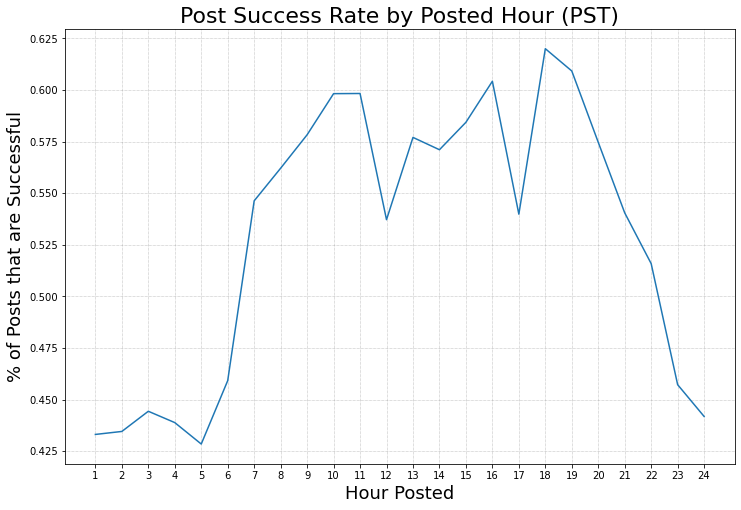

In [54]:
plt.figure(figsize=(12, 8))
plt.plot('posted_hour',
         'success_rate', 
         data=temp_df
        )
plt.xticks(temp_df['posted_hour'])
plt.title('Post Success Rate by Posted Hour (PST)', size = 22)
plt.ylabel('% of Posts that are Successful', size = 18)
plt.xlabel('Hour Posted', size = 18)
plt.grid(color='grey', linestyle=':', linewidth=0.5)
plt.savefig('../visualizations/succ_rate_by_hour.png')
;

The above graph indicates that posting between 7:00 am and 8:00pm PST gives your post the best chance at success, with a maximum success rate at 6:00 pm.

In [55]:
#creating a temporary data frame that allows me to chart the number of posts by hour

temp_df = reddit['posted_hour'].value_counts().to_frame().reset_index()
temp_df.rename(columns = {'index':'hour','posted_hour':'count'}, inplace = True)
temp_df = temp_df.sort_values('hour')

''

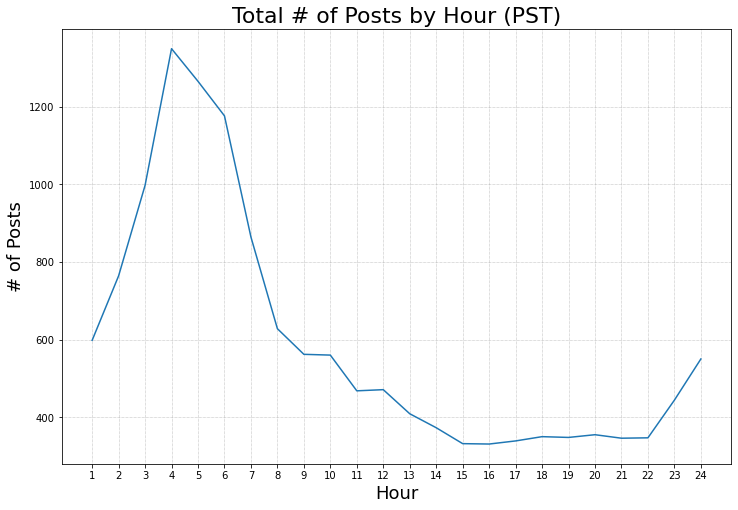

In [56]:
plt.figure(figsize=(12, 8))
plt.plot('hour',
         'count', 
         data=temp_df,
        )
plt.xticks(temp_df['hour'])
plt.title('Total # of Posts by Hour (PST)', size = 22)
plt.ylabel('# of Posts', size = 18)
plt.xlabel('Hour', size = 18)
plt.grid(color='grey', linestyle=':', linewidth=0.5)
plt.savefig('../visualizations/num_posts_by_hour.png')
;

Interesting to see that the number of posts per hour and the success rate of posts are inversion of one another. We see the higest number of posts per hour between 3 and 6 am PST, where we see the lowest success rate of posts. 

In [57]:
temp_df

,hour,count
7,1,598
5,2,764
3,3,997
0,4,1349
1,5,1265
2,6,1176
4,7,864
6,8,628
8,9,562
9,10,560


In [58]:
temp_df = reddit.groupby('posted_hour')['comments'].median().to_frame().reset_index()
temp_df.rename(columns = {'posted_hour':'hour'}, inplace = True)
temp_df = temp_df.sort_values('hour')

''

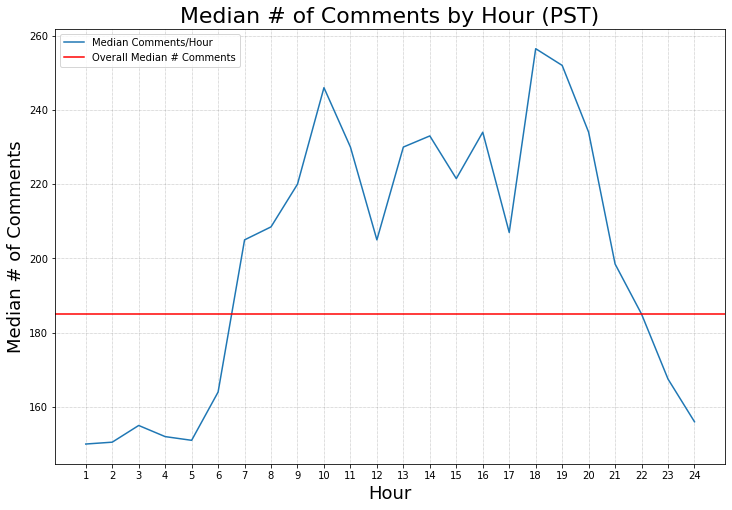

In [59]:
plt.figure(figsize=(12, 8))
plt.plot('hour',
         'comments', 
         data=temp_df,
        )
plt.xticks(temp_df['hour'])
plt.title('Median # of Comments by Hour (PST)', size = 22)
plt.ylabel('Median # of Comments', size = 18)
plt.xlabel('Hour', size = 18)
plt.grid(color='grey', linestyle=':', linewidth=0.5)
plt.axhline(y=reddit['comments'].median(), color = 'r')
plt.legend(['Median Comments/Hour', 'Overall Median # Comments'], loc = 'best')
plt.savefig('../visualizations/num_comments_by_hour.png')
;

In [60]:
#creating a temporary dataframe to chart the number of successful posts and 
#percentage of successful posts by subreddit (top 40)
#number of successful posts in each subreddit
temp_df = reddit.groupby('subreddit')['target'].sum().to_frame().reset_index()
#percentage of posts that are successful in each subreddit
temp_df2 = reddit.groupby('subreddit')['target'].mean().to_frame().reset_index()
temp_df['perc_success'] = temp_df2['target']
#converting percentage to string for graph labeling purposes
temp_df['perc_success'] = temp_df['perc_success'].apply(lambda x: str(round(100*x)) + '%')
#sorting the dataframe based on number of successful posts
temp_df = temp_df.sort_values('target', ascending = False)
#taking the top 20 subreddits with the largest number of successful posts
top_20 = temp_df.head(20)

top_20.rename(columns = {'target':'#_good_posts','perc_success':'success_rate'})


,subreddit,#_good_posts,success_rate
655,/r/antiwork/,79,89%
1038,/r/politics/,66,93%
624,/r/WhitePeopleTwitter/,63,85%
1142,/r/teenagers/,61,98%
980,/r/nextfuckinglevel/,61,81%
288,/r/HolUp/,60,83%
815,/r/facepalm/,58,85%
850,/r/gaming/,57,81%
1029,/r/pics/,57,88%
600,/r/Unexpected/,54,77%


Text only posts seem to do better, and so the subreddits with the greatest number of successful posts where text only posts might thrive are antiwork, teenagers, nba, and formula1.